# Importo le librerie e i pacchetti necessari

In [ ]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

# Definisco alcune funzioni

In [ ]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [ ]:
# multi-step data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = list(sequence['Value'][i:end_ix]), list(sequence['Value'][end_ix:out_end_ix])
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

# Importo i dati

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/streaming data management/progetto')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('TrainingSet.csv', sep=';', header=0, low_memory=False)
data.rename(columns={"DATA": "Date", "Ora": "Hour", "VALORE": "Value"}, inplace=True)

In [ ]:
data.info()
#tehre aren't missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17518 non-null  object
 1   Hour    17518 non-null  int64 
 2   Value   17518 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 410.7+ KB


In [ ]:
#according to the standard of the dates the hours are from 0-23. So I replace 24 with 0
data['Hour']=data['Hour']-1
data['Hour']=data['Hour'].astype(str)
#trasform into datetime object
data['Date_Hour']=pd.to_datetime(data['Date']+'-'+data['Hour'],  format = "%Y-%m-%d-%H" )
#delete the columns that are no longer needed
data.drop(['Date', 'Hour'], axis='columns', inplace=True)

In [ ]:
#duplicates
print('Are there duplicates?', data['Date_Hour'].nunique()!=data.shape[0])
#there are no duplicates

Are there duplicates? False


In [ ]:
#check that there are no missing dates within the dataset.
#Transform the datatime column (containing date and time) into index by also inserting the missing dates
r = pd.date_range(start=data['Date_Hour'].min(), end=data['Date_Hour'].max(), freq='H')
data.set_index('Date_Hour', inplace=True)
data=data.reindex(r)
data.index.rename('Date_Hour', inplace=True)

In [ ]:
#missing dates
data.index[data['Value'].isnull()]

DatetimeIndex(['2019-03-31 02:00:00', '2020-03-29 02:00:00',
               '2020-05-31 00:00:00', '2020-05-31 01:00:00',
               '2020-05-31 02:00:00', '2020-05-31 03:00:00',
               '2020-05-31 04:00:00', '2020-05-31 05:00:00',
               '2020-05-31 06:00:00', '2020-05-31 07:00:00',
               '2020-05-31 08:00:00', '2020-05-31 09:00:00',
               '2020-05-31 10:00:00', '2020-05-31 11:00:00',
               '2020-05-31 12:00:00', '2020-05-31 13:00:00',
               '2020-05-31 14:00:00', '2020-05-31 15:00:00',
               '2020-05-31 16:00:00', '2020-05-31 17:00:00',
               '2020-05-31 18:00:00', '2020-05-31 19:00:00',
               '2020-05-31 20:00:00', '2020-05-31 21:00:00',
               '2020-05-31 22:00:00', '2020-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Date_Hour', freq=None)

Mancano i valori associati alle datetime 2019-03-31 03:00:00 e 2020-03-29 03:00:00 (tutti gli orari sono da considerrare un'ora indietro a causa dell'operazione che ho fatto affinchè i dati fossero nel formato standard di Pandas) a causa del passaggio ad ora solare-legale. Come consigliato da chi ci ha fornito il dataset sostituisco i due valori mancanti con il valore all'ora precedente.

In [ ]:
#as professor said, for the two missing time values ​​I insert the value of the previous hour
data.loc["2019-03-31 02:00:00"][0]=data.loc["2019-03-31 01:00:00"][0]
data.loc["2020-03-29 02:00:00"][0]=data.loc["2020-03-29 01:00:00"][0]

Mancano anche tutti i valori associati alla data 2020-05-31. Non ho trovato niente di particolare quel giorno a parte che era la domenica di pentecoste.
Poiché, come si vedrà più avanti, c'è una stagionalità settimanale oltre che giornaliera, ho deciso di sostituire i valori mancanti del 2020-05-31 con una media dei valori una settimana prima e una dopo alla stessa ora. In realtà inizialmente avevo costruito un modello lstm (codice in coda) per prevedere tali valori. Confrontando i risultati, non c'è molta differenza.

In [ ]:
a=0
for i in pd.date_range(start="2020-05-31 00:00:00", end="2020-05-31 23:00:00", freq='H'):
  data.loc[i,'Value']=(data.loc[pd.to_datetime(i)-datetime.timedelta(days=7),'Value']+data.loc[pd.to_datetime(i)+datetime.timedelta(days=7),'Value'])/2
  a=a+1

In [ ]:
#save the dataset in a csv file. I will use it to build the models to make predictions
data.to_csv('data_complete.csv')

#Visualizzazioni iniziali

In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)

In [ ]:
data['Year']=data.index.year
data['Month']=data.index.month
data['Dayofweek']=data.index.day_name()
data['Day']=data.index.day
data['Hour']=data.index.hour

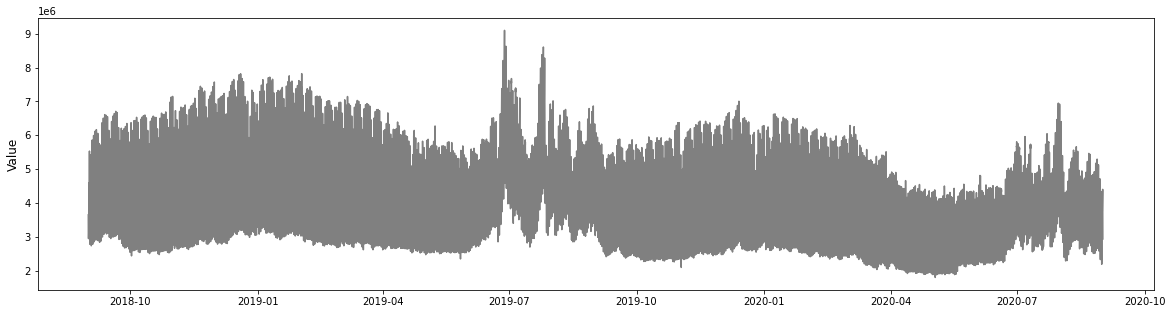

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['Value'], color='gray')
plt.ylabel('Value', fontsize = 12)
plt.show()

Sembrano esserci dei valori anomali verso fine giugno e fine luglio 2019. Se conoscessimo cosa rappresentano i dati forse potremmo analizzare meglio queste anomalie ed eventualmente introdurre delle variabili che le giustifichino.

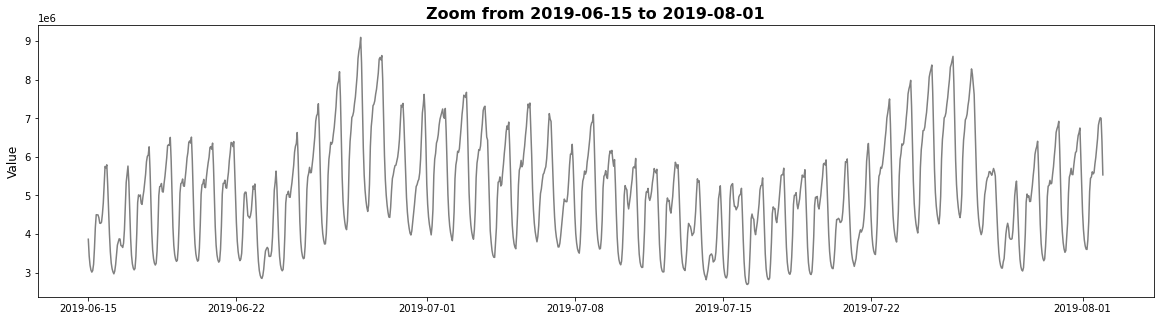

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data.loc["2019-06-15 00:00:00":"2019-08-01 23:00:00"]['Value'], color='gray')
plt.ylabel('Value', fontsize = 12)
plt.title('Zoom from 2019-06-15 to 2019-08-01', fontsize = 16, fontdict=dict(weight='bold'))
plt.show()

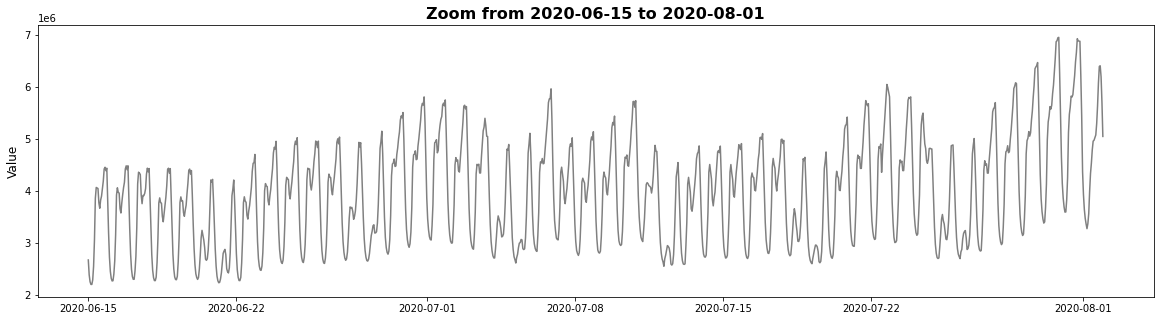

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data.loc["2020-06-15 00:00:00":"2020-08-01 23:00:00"]['Value'], color='gray')
plt.ylabel('Value', fontsize = 12)
plt.title('Zoom from 2020-06-15 to 2020-08-01', fontsize = 16, fontdict=dict(weight='bold'))
plt.show()

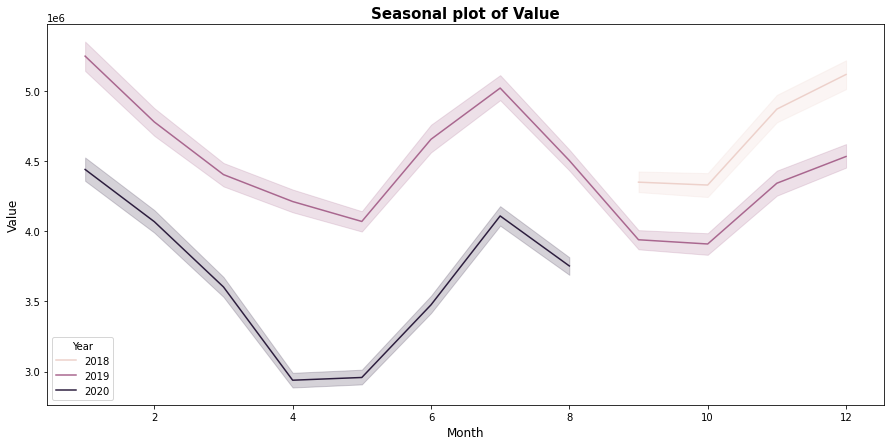

In [ ]:
#LINEPLOT: 
#By default, the plot aggregates over multiple y values at each value of x and 
#shows an estimate of the central tendency and a confidence interval for that estimate.

plt.figure(figsize=(15, 7))
sns.lineplot(data['Month'], data['Value'], hue=data['Year'])
plt.title('Seasonal plot of Value', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

Vi è chiaramente un andamento stagionale annuale: si notano dei picchi nei mesi di dicembre-gennaio e luglio. Sembra esserci anche un trend decrescente col passare degli anni, ipotesi confermata dal box plot di sinistra. Nei mesi di marzo-aprile-maggio 2020 si nota chiaramente una decrescita anomala dovuta al covid-19.

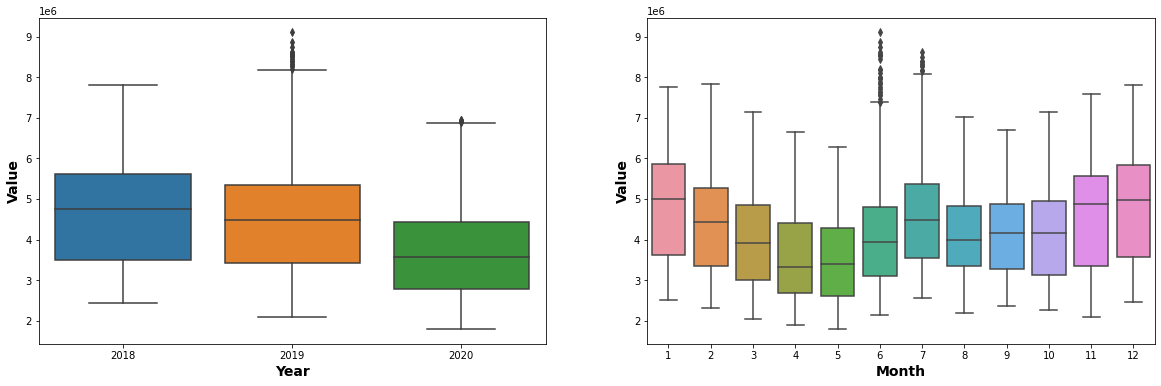

In [ ]:
#boxplot del valore rispetto a mese e anno
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.boxplot(data['Year'], data['Value'], ax=ax[0])
ax[0].set_xlabel('Year', fontsize = 14, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Value', fontsize = 14, fontdict=dict(weight='bold'))


sns.boxplot(data['Month'], data['Value'], ax=ax[1])
ax[1].set_xlabel('Month', fontsize = 14, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Value', fontsize = 14, fontdict=dict(weight='bold'))
plt.show()

I box plot confermano la presenza di outliers nei mesi di giugno e luglio del 2019. L'andamento intra annuo nel grafico di destra non è più così chiaramente visibile come lo era nel grafico precedente.

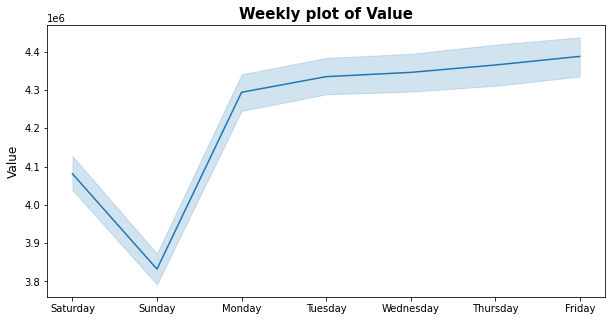

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data['Dayofweek'], data['Value'])
plt.title('Weekly plot of Value', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.ylabel('Value', fontsize = 12)
plt.xlabel('', fontsize = 12)
plt.show()

Vi è anche un andamento infrasettimanale: nel weekend (giorni 5 e 6) i valori diminuiscono vistosamente.

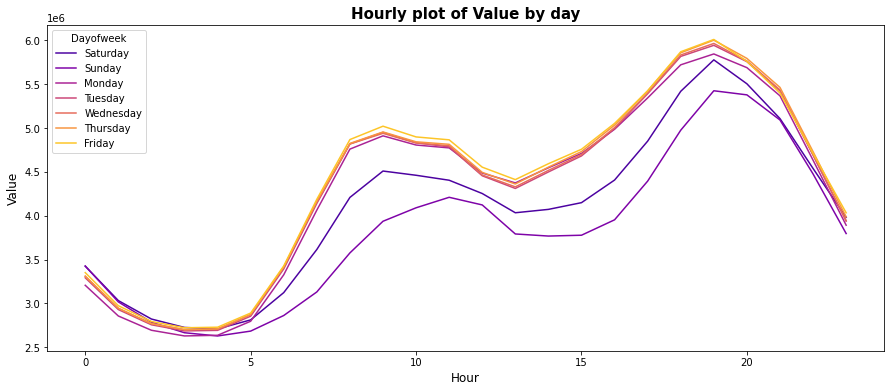

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data['Hour'], data['Value'], hue=data['Dayofweek'], ci=None, palette="plasma")
plt.title('Hourly plot of Value by day', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

Vi è chiaramente un andamento giornaliero: ci sono dei picchi verso le 10 e le 20. La domenica il picco mattutino è verso mezzogiorno.  

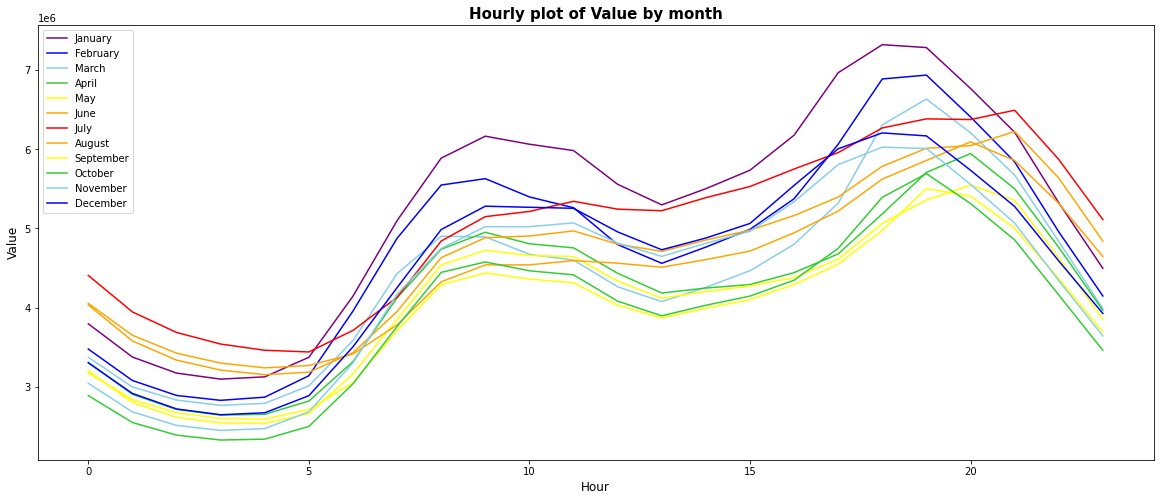

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(data.loc["2019-01-01 00:00:00":"2019-12-31 23:00:00"]['Hour'], data['Value'], hue=data['Month'], ci=None, 
             palette=["purple","blue","skyblue","limegreen","yellow","orange","red","orange","yellow","limegreen","skyblue","blue"])
plt.title('Hourly plot of Value by month', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.show()

Come si vede dal grafico la stagionalità giornaliera varia al variare dei mesi. Nei mesi estivi (colori giallo-arancio-rosso) i picchi sono una-due ore in ritardo rispetto ai picchi dei mesi invernali (colori azzurro-blu-viola).  

Adesso visualizzo solo una certa ora così è graficamente più chiara la stagionalità settimanale e annuale.

In [ ]:
hour=15
data_hour=data[data['Hour']==hour]

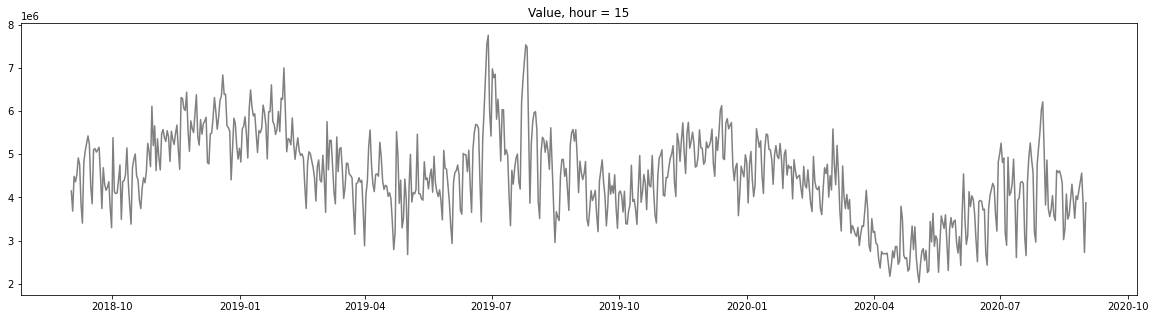

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data_hour['Value'], color='gray')
plt.title('Value, hour = {}'.format(hour) , fontsize = 12)
plt.show()

Un modo alternativo è fare la media giornaliera dei dati. 

In [ ]:
data['Date']=pd.to_datetime(data['Year'].astype('str')+'-'+data['Month'].astype('str')+'-'+data['Day'].astype('str'),  format = "%Y-%m-%d" )
pivot=data.pivot_table(index='Date', values='Value', aggfunc='mean')

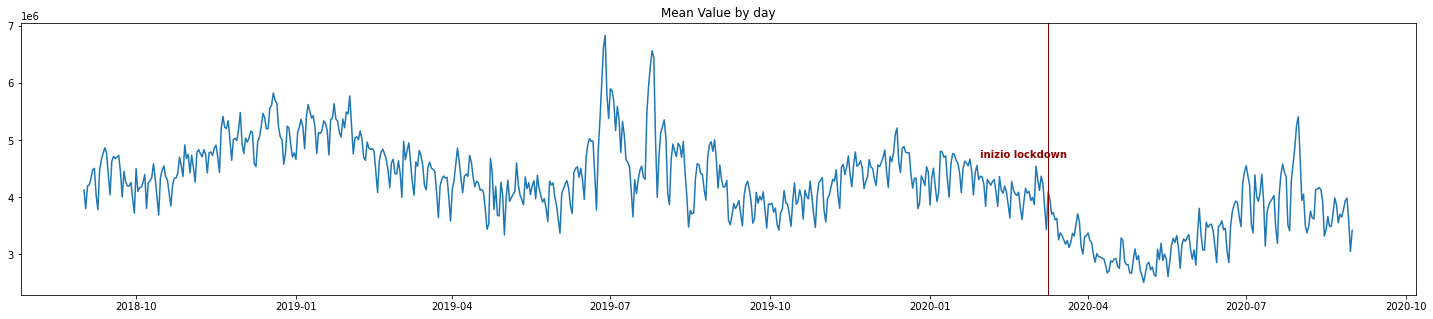

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(pivot['Value'])
plt.axvline(x=pivot.index[pivot.index=="2020-03-09"], color='darkred', linewidth=1)
plt.text(pivot.index[pivot.index=="2020-01-30"], 4.7e06, 'inizio lockdown',  fontdict=dict(weight='bold'), color='darkred')
plt.title('Mean Value by day')
plt.show()
plt.savefig('destination_path.png', format='png')

Il covid sembra aver fortemente influenzato i dati: in questo periodo la serie oltre a diminuire in modo anomalo, presenta una variabilità settimanale molto inferiore rispetto al resto dell'anno. Creo quindi una variabile, covid, che assume valore 1 dopo il 2020-03-09, 0 prima.

In [ ]:
data['covid']=0
data.loc["2020-03-09 00:00:00":]['covid']=1

In [ ]:
data.to_csv('data_info.csv')

Da queste prime analisi visuali la serie sembra essere influenzata oltre che da fenomeni naturali, anche da fenomeni artificiali. Potrebbe aver senso introdurre delle variabili dummy contenenti le festività. Poichè abbiamo a disposizione solo due anni di dati, e poichè nei grafici non si notano evidenti anomalie nei giorni legati alle festività (ma solo verso luglio-agosto), decido di non introdurre variabili dummy per rappresentare questi eventi.


#Divisione train e validation set
In tutti i modelli utilizzerò come validation set gli ultimi 4 mesi. In questo modo nel train sono presenti sia marzo e aprile 2020, primi mesi in cui i valuri subiscono una variazione a causa del covid.

In [ ]:
train=data.loc[:"2020-04-30 23:00:00"]
validation=data.loc["2020-05-01 00:00:00":]

In [ ]:
print('Observations Train: {} --- {}%'.format(len(train), (round(len(train)/len(data)*100, 2))))
print('Observations Validation: {} --- {}%'.format(len(validation), (round(len(validation)/len(data)*100, 2))))

Observations Train: 14592 --- 83.17%
Observations Validation: 2952 --- 16.83%


#Appendice: Multi-step univariate LSTM Model
Inizialmente avevo costruito un modello LSTM per prevedere i dati mancanti del 31/05/2020

In [ ]:
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import LSTM, Dense, Activation, BatchNormalization, Dropout, LeakyReLU
from sklearn.preprocessing import StandardScaler

In [ ]:
train_st=data.loc[:"2020-05-30 23:00:00"].copy()
train_st['Value'], scaler1 = preprocess_data(train_st)

In [ ]:
# choose a number of time steps
n_steps_in, n_steps_out = 24, 24   #24*7=168
# split into samples
X, y = split_sequence(train_st, n_steps_in, n_steps_out)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps_in, n_features)))  #
model.add(Dropout(0.1))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
model.summary()

model.fit(X, y, epochs=5, verbose=1)

In [ ]:
x_input = np.array(train_st[-24:])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

In [ ]:
yhat = scaler1.inverse_transform(yhat)

In [ ]:
a=0
for i in pd.date_range(start="2020-05-31 00:00:00", end="2020-05-31 23:00:00", freq='H'):
  data.loc[i]['Value']=round(yhat[0][a], 1)  #cosi modifica il dataset originale!
  a+=1